<a href="https://colab.research.google.com/github/tmor8832/NaturalLanguageProcessing/blob/master/Python__Live_Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This code will connect to twitter API and monitor real time tweets for key words and phrases. Written by Thomas Morris

In [116]:
# Install Geopandas, this is used for the map for plotting the tweets and also dataset for SQL database storing
!pip install dataset
!pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-kxn8pag2
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-kxn8pag2


In [117]:
#import the relevant libraries
import dataset
import tweepy #used to access twitter API
from textblob import TextBlob #used for common NLP tasks and analysis
from wordcloud import WordCloud #for generating a wordcloud image
import pandas as pd #used for creating dataframes
import numpy as np #arrays etc
import seaborn as sns #graphical library
import itertools #used for nice loops and iterations
import collections
import re #regular expressions, useful for NLP
import json
import matplotlib.pyplot as plt #useful for visualisation of data
import geopandas as gpd 
import plotly.express as px

In [119]:
#Store all functions in this section

#Extract the data from the CSV file and store as variables
def credentials(log):
  ConsumerKey = log['key'][0]
  ConsumerKeySecret = log['key'][1]
  AccessToken = log['key'][3]
  AccessTokenSecret = log['key'][4]
  api = authenticate(ConsumerKey, ConsumerKeySecret, AccessToken, AccessTokenSecret)
  return api

#Create the authentication object to connect to the twitter API
def authenticate(ConsumerKey, ConsumerKeySecret, AccessToken, AccessTokenSecret): 
  authenticate = tweepy.OAuthHandler(ConsumerKey, ConsumerKeySecret)
  authenticate.set_access_token(AccessToken, AccessTokenSecret)
  api = tweepy.API(authenticate, wait_on_rate_limit=True)
  return api


#Clean the tweets to remove unwanted characters and data
def cleanTweet (tweet):
  tweet = re.sub('#bitcoin', 'bitcoin', tweet) #Remove hashtag from bitcoin or Bitcoin
  tweet = re.sub('#Bitcoin', 'Bitcoin', tweet) #Adjust this as needed for the specific search term
  tweet = re.sub('#[A-Za-z0-9]+', '', tweet) #Remove any strings with a hashtag
  tweet = re.sub('@[A-Za-z0-9]+', '', tweet) #Remove any strings with a hashtag
  tweet = re.sub('$[A-Za-z0-9]+', '', tweet) #Remove any strings with a hashtag
  tweet = re.sub('[!,*)@#%(&$_?.^]', '', tweet)
  tweet = re.sub('\\n', '', tweet) #removing the '\n' string
  tweet = re.sub('https', '', tweet) #remove any hyperlinks
  tweet = re.sub('http', '', tweet) #remove any hyperlinks
  return tweet

def cleanTweetofCommon (tweet):
  tweet = tweet.lower()
  tweet = re.sub('and', '', tweet) 
  tweet = re.sub('or', '', tweet) 
  tweet = re.sub('it', '', tweet) 
  tweet = re.sub('of', '', tweet) 
  tweet = re.sub('the', '', tweet) 
  tweet = re.sub('to', '', tweet)
  tweet = re.sub('a', '', tweet) 
  tweet = re.sub('is', '', tweet) 
  tweet = re.sub('it', '', tweet) 
  tweet = re.sub('ok', '', tweet) 
  tweet = re.sub('but', '', tweet)
  tweet = re.sub('in', '', tweet)
  tweet = re.sub('got', '', tweet) 
  return tweet

# Use of textblob NLTK lib https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524
#create a function to get the subjectivity, values between 0 and 1 where 1 is a high degree of personal opinion and not fact
def getSubjectivity(tweet):
  return TextBlob(tweet).sentiment.subjectivity

#create a function to get the polarity, values bwteen [-1:1] -1 is negative, 1 is a positive sentiment
def getPolarity(tweet):
  return TextBlob(tweet).sentiment.polarity 

#create a function to get the sentiment text
def getSentiment(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive' 

def get_coords(coords): #Split lat and long data from the string
  x=0
#for loop to get coordinate data from the tweets and appends to the variables above
  for x in range(len(coords)):
    if str(coords[x]) == 'None':
      lat = 0.0
      lng = 0.0
      latitude.append(lat)
      longitude.append(lng)
      x = x+1
    else: #if no coordinates found, give default 0,0
      a = coords[x]
      s = str(a)
      result = s[s.find('[')+1:s.find(']')]
      lat,lng = result.split(',')
      latitude.append(lat)
      longitude.append(lng)
      x = x+1
  return latitude, longitude

In [120]:
from google.colab import files
files.upload()
log = pd.read_csv('Login.csv')

Saving Login.csv to Login (1).csv


In [121]:
#override tweepy.StreamListener to add logic to on_status
# Guidance for using stream at https://www.dataquest.io/blog/streaming-data-python/
api = credentials(log)
tweet_text = []
coords = []
loc = []
name  = []
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
      #if 'and' in status.text.lower(): #this could be used to further filter words within a location (only way to apply AND logic to filtering)
            coords.append(status.coordinates)
            tweet_text.append(status.text)
            loc.append(status.user.location)
            name.append(status.user.screen_name)
            print(status.text)
            # description = status.user.description
            # followers = status.user.followers_count
            # id_str = status.id_str
            # created = status.created_at
            # retweets = status.retweet_count
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False

    def on_timeout(self):
      return True  # Don't kill the stream
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth=api.auth, listener=myStreamListener)
myStream.filter(locations=[-122.75,36.8,-121.75,37.8,-74,40,-73,41]) #Filter tweets by location determined by coordinates (SAN FRAN or NEW YORK)
#MyStream.filter(track=['star wars', 'cheese']) #use this to filter tweets by key words

KeyboardInterrupt: ignored

In [126]:
#create lat and long variables to store the coordinate data in
#print(coords)
latitude= []
longitude = []

latitude, longitude = get_coords(coords)

combined_information = {'Username': name, 'Tweets': tweet_text, 'Longitude': longitude, 'Latitude': latitude }

df = pd.DataFrame(combined_information)

df.head()

,Username,Tweets,Longitude,Latitude
0,mattbwhitlock12,Morning. https://t.co/dBYGcaT9mv,0,0
1,JoanneGoscicki,🙏🙏🙏,0,0
2,El_Rey_Pobre,@JossetDiaz SIGN EL CUAH YOU COWARDS LOL,0,0
3,tmj_NYC_secure,"Want to land a job like ""Asset Protection Coor...",40.759498,-73.9958552
4,samorius,"@AndyBryanLewis Al carajo LOL, pero Arcane est...",0,0


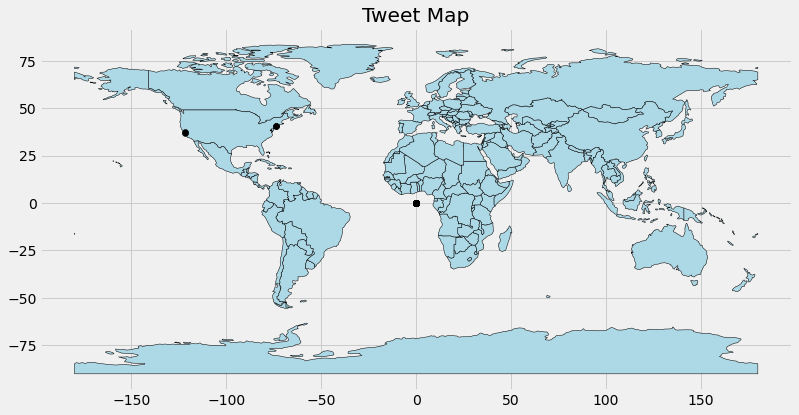

In [127]:
#Now plot the coordinates on a map, not always applicable as does not always give coordinates
df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Latitude, df.Longitude))
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
axis = world_data.plot(color = 'lightblue', edgecolor = 'black')
#axis = world_data[world_data.continent == 'North America'].plot(color = 'lightblue', edgecolor = 'black')
df_geo.plot(ax=axis, color = 'black')
plt.title('Tweet Map')
fig = plt.gcf()
fig.set_size_inches(12,12)
fig.savefig('matplot.png', dpi = 200)
plt.show()

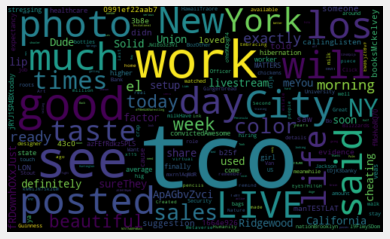

In [105]:
#Plot a word cloud
allWords = ''.join([twts for twts in df['Tweets']])
wordcloud = WordCloud(width = 500, height = 300, random_state= 21, max_font_size=119).generate(allWords)
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Now do sentiment analysis on the tweets to determine sentiment 

In [106]:
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity) #df to hold subjectivity
df['Polarity'] = df['Tweets'].apply(getPolarity)#df to hold polarity
df['Sentiment'] = df['Polarity'].apply(getSentiment) #create a column to store the text sentiment

#print positive tweets
j=1
sortedDF = df.sort_values(by=['Polarity'])
for i in range (0, sortedDF.shape[0]):
  if (sortedDF['Sentiment'][i]=='Positive'):
    print(str(j) + ')' + sortedDF['Tweets'][i])
    print()
    j = j+1

1) Dude is doing his share of the work and more that’s for sure

2)  Solid suggestion I loved those books

3) There is too much evidence They all will be convicted

4)Awesome 👏

5)🏠 WHERE YOU LIVE MATTERS:New York state has a higher average life expectancy than the nationBrooklyn has a hig… ://tco/l9FlwySDom

6) Great to see you as well 😘

7)Guinness Gingerbread Stout bottles now available ://tco/mxrn1AqMdR  

8)Have you ever had a role like "Security Officer- University" What did you like most about that job  

9)Other men walk around New York City with designer bags meanwhile I stay in touch with my roots 😌 ://tco/oYm9NQogF4

10)Metaverse real estate sales remind me of Second Life virtual home sales from ~15 years ago; remember this million d… ://tco/EWd6jZtBvF

11)GM beautiful people 123 or 4 from last week ://tco/dfYBe6U80V

12) is good but the season passes need some serious work  

13) Thanks Liam

14) That’s exactly how i’m looking at it Took a look a doge coin at 16-17 cents 👀


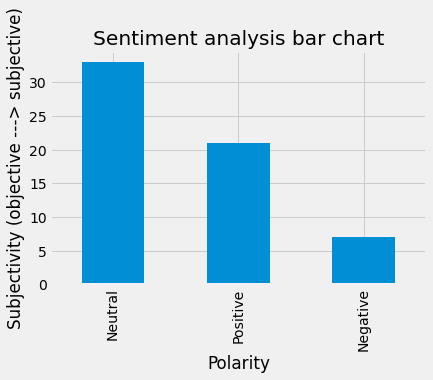

In [107]:
#Visualise the sentiment analysis data, how many of each type of tweet was there
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment analysis bar chart')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity (objective ---> subjective)')
plt.show()